In [135]:
%matplotlib inline
from json.decoder import JSONDecodeError
from satsearch import Search
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
from pyproj import Transformer
from json import load
import rasterio
import rasterio.mask
import rasterio.transform
from rasterio.features import bounds
import math
from tempfile import NamedTemporaryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [136]:
def get_file_geometry(file_path:str):
    with open(file_path,"r") as fp:
        try:
            file_content = load(fp)
            if file_content["type"] == "Feature":
                file_content = file_content["geometry"]
            elif file_content["type"] == "FeatureCollection":
                file_content = file_content["features"][0]["geometry"]
            return file_content
        except JSONDecodeError:
            print("Provided json file is not valid.")
            return None

In [137]:
def get_bounding_box(geometry):
    return bounds(geometry)

In [138]:
def get_ndvi(nir, red):
    nir = nir.astype(float)
    red = red.astype(float)
    return (nir-red)/(nir+red)

In [139]:
print("hi")

hi


(12.969017028808594, 52.45946123411788, 13.10068130493164, 52.53460237630518)
EPSG:32633
| 10.00, 0.00, 300000.00|
| 0.00,-10.00, 5900040.00|
| 0.00, 0.00, 1.00|
BoundingBox(left=300000.0, bottom=5790240.0, right=409800.0, top=5900040.0)
bbox0: 12.969017028808594 bbox3: 52.53460237630518
(362246.38702229917, 5822439.143987225) (370955.9282660864, 5813839.0262271995)
(362246.38702229917, 5822439.143987225) (371155.9282660864, 5814039.0262271995)

coords1: (362246.38702229917, 5822439.143987225) 
coords2: (371155.9282660864, 5814039.0262271995) 
pixles1: (7760, 6224) 
pixels2: (8600, 7115)

 extend_row: 840

 extend_col: 891


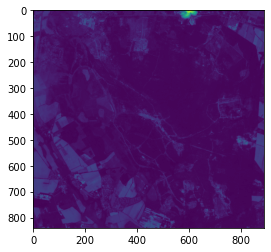

Window(col_off=6224, row_off=7760, width=891, height=840)
362246.38702229917 5822439.143987225 371155.9282660864 5814039.0262271995 891 840
|-10.00, 0.00, 371155.93|
| 0.00,-10.00, 5822439.14|
| 0.00, 0.00, 1.00|


| 10.00, 0.00, 362246.39|
| 0.00,-10.00, 5822439.14|
| 0.00, 0.00, 1.00|


| 10.00, 0.00, 300000.00|
| 0.00,-10.00, 5900040.00|
| 0.00, 0.00, 1.00|
EPSG:4326
BoundingBox(left=12.969017028808594, bottom=52.45908711600688, right=13.103514456409867, top=52.536782839300265)
{'type': 'Polygon', 'coordinates': [[[13.09621810913086, 52.468560246396606], [13.10068130493164, 52.52154811647113], [13.06617736816406, 52.53460237630518], [13.01107406616211, 52.53272280202344], [13.010902404785156, 52.52906784393992], [13.001804351806639, 52.528127948407935], [12.996997833251951, 52.5296944297867], [12.98309326171875, 52.52353261403368], [12.989788055419922, 52.5131913538099], [12.969017028808594, 52.514236036066244], [12.987041473388672, 52.49783165855702], [13.05776596069336, 52.4594612

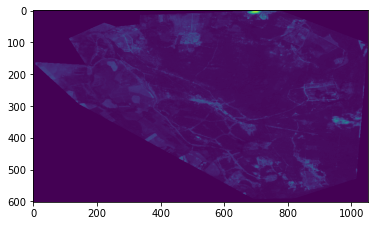

dataset center: (354905.0, 5845135.0)
dataset center: (52.736588912690266, 12.850886374198192)
dataset center trans back: (354905.0000000001, 5845135.0)
dataset center back (5490, 5490)
bbox: [52.53460237630518, 12.969017028808594]
bbox trans back: (362246.38702229917, 5822439.143987225)
bbox back: (7760, 6224)
ds left upper: (300005.0, 5900035.0) (53.211934822877524, 12.004838827136357)
ds right lower: (409805.0, 5790235.0) (52.255106627164054, 13.678618631038752)


In [161]:
def get_latest_sentinel_files(geometry:object):
    # search last 30 days
    current_date = datetime.now()
    date_30_days_ago = current_date - timedelta(days=30)
    current_date = current_date.strftime("%Y-%m-%d")
    date_30_days_ago = date_30_days_ago.strftime("%Y-%m-%d")

    # only request images with cloudcover less than 20%
    query = {
            "eo:cloud_cover": {
                "lt": 20
                }
            }

    search = Search(
        url='https://earth-search.aws.element84.com/v0',
        bbox=get_bounding_box(geometry),
        datetime=date_30_days_ago + "/" + current_date,
        collections=['sentinel-s2-l2a-cogs'],
        query=query
        )


    items = search.items()

    # grep latest red && nir
    red = items[0].asset('red')["href"]
    nir = items[0].asset('nir')["href"]

    with rasterio.open(red) as red_fp:
        # overviews
        data = red_fp.meta

        geom = get_file_geometry("../example/doberitzer_heide.geojson")
        bbox = get_bounding_box(geom)

        transformer_to = Transformer.from_crs("epsg:4326", red_fp.crs) 
        
        for idx,i in enumerate(geom["coordinates"]):
            for idy,j in enumerate(i):
                new_coords = transformer_to.transform(j[1], bbox[0])
                #geom["coordinates"][idx][idy] = [new_coords[0], new_coords[1]]            
        
        print(bbox)
        print(red_fp.crs)
        print(red_fp.transform)
        print(red_fp.bounds)
        
        print("bbox0:", bbox[0], "bbox3:",bbox[3])
        
        coords1 = transformer_to.transform(bbox[3], bbox[0])
        coords2 = transformer_to.transform(bbox[1], bbox[2])
        
        print("coords1:", coords1, coords2)
        
        coords1 = (coords1[0], coords1[1])
        coords2 = (coords2[0] + 200, coords2[1] + 200) # enhance bounding box
        
        print(coords1, coords2)
        
        pixels1 = red_fp.index(coords1[0], coords1[1])
        pixels2 = red_fp.index(coords2[0], coords2[1])
        
        print("\ncoords1:",coords1,
              "\ncoords2:",coords2,
              "\npixles1:",pixels1,
              "\npixels2:",pixels2)    
        
        extend_row = pixels2[0] - pixels1[0]
        extend_col = pixels2[1] - pixels1[1]
        
        print("\n extend_row:", extend_row)
        print("\n extend_col:", extend_col)
        
        window = rasterio.windows.Window.from_slices((pixels1[0], pixels2[0]), (pixels1[1], pixels2[1]))
        
        subset = red_fp.read(1, window=window)
        
        plt.imshow(subset)
        plt.show()
            
            
        print(window)
        affine = rasterio.transform.from_bounds(coords2[0],coords2[1],  
                                                coords1[0],coords1[1],
                                                window.width,
                                                window.height)
        
        affine2 = rasterio.transform.from_origin(coords1[0], coords1[1], 10, 10)
        
        print(coords1[0],
                                                coords1[1],                                                 
                                                coords2[0],
                                                coords2[1],
                                                window.width,
                                                window.height)

        print(affine)
        print("\n")
        print(affine2)
        print("\n")
        print(red_fp.transform)
        dtype = subset.dtype
        
        dst_crs = 'EPSG:4326'
        
        with NamedTemporaryFile() as tmp:
            with rasterio.open(tmp.name, 'w', driver='GTiff', dtype=dtype,
                                  count=1, height=window.height, width=window.width, crs=red_fp.crs, transform=affine2) as subset_fp:
                subset_fp.write(subset, 1)               
                
            with rasterio.open(tmp.name, 'r') as subset_fp:
                #print(geom)
                #print(subset_fp.bounds)
                #out_img, out_trans = rasterio.mask.mask(subset_fp, [geom], crop=True)
                
                
                transform, width, height = calculate_default_transform(
                    subset_fp.crs, dst_crs, subset_fp.width, subset_fp.height, *subset_fp.bounds)
                kwargs = subset_fp.meta.copy()
                kwargs.update({
                    'crs': dst_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                 
                with NamedTemporaryFile() as tmp2:
                    with rasterio.open(tmp2.name, 'w', **kwargs) as dst:
                        for i in range(1, subset_fp.count + 1):
                            reproject(
                                source=rasterio.band(subset_fp, i),
                                destination=rasterio.band(dst, i),
                                src_transform=subset_fp.transform,
                                src_crs=subset_fp.crs,
                                dst_transform=transform,
                                dst_crs=dst_crs,
                                resampling=Resampling.nearest)
                        
                    with rasterio.open(tmp2.name) as dst:
                        out_img, out_trans = rasterio.mask.mask(dst, [geom], crop=True)
                        out_meta = dst.meta
                        
                        out_meta.update({"driver": "GTiff",
                         "height": out_img.shape[1],
                         "width": out_img.shape[2],
                         "transform": out_trans})
                        with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
                            dest.write(out_img)
                        
                        print(dst.crs)
                        print(dst.bounds)
                        print(geom)
                        print(out_img)
                        print(out_trans)
                        plt.imshow(out_img[0])
                        plt.show()
                
        
        transformer_back = Transformer.from_crs(red_fp.crs, "epsg:4326") 
        
        ds_left_upper = red_fp.xy(0,0) 
        ds_right_lower = red_fp.xy(red_fp.height, red_fp.width)        
        ds_center = red_fp.xy(red_fp.height // 2, red_fp.width // 2)
        
        ds_left_upper_trans = transformer_back.transform(ds_left_upper[0], ds_left_upper[1])
        ds_right_lower_trans = transformer_back.transform(ds_right_lower[0], ds_right_lower[1])
        ds_center_trans = transformer_back.transform(ds_center[0],ds_center[1])
        
        print("dataset center:", ds_center)
        print("dataset center:", ds_center_trans)
        
        # back
        ds_center_trans_back = transformer_to.transform(ds_center_trans[0], ds_center_trans[1])
        print("dataset center trans back:", ds_center_trans_back)
        ds_center_back = red_fp.index(ds_center_trans_back[0], ds_center_trans_back[1])
        print("dataset center back", ds_center_back)
        
        bbox = [52.53460237630518, 12.969017028808594]
        bbox_trans_back = transformer_to.transform(bbox[0], bbox[1])
        bbox_back = red_fp.index(bbox_trans_back[0], bbox_trans_back[1])
        
        print("bbox:", bbox)
        print("bbox trans back:", bbox_trans_back)
        print("bbox back:", bbox_back)
        
        print("ds left upper:", ds_left_upper, ds_left_upper_trans)
        print("ds right lower:", ds_right_lower, ds_right_lower_trans)
        
        #print("dataset center:", red_fp)       
        #extend1 = coords[1][0] - coords[0][0]
        #extend2 = coords[1][1] - coords[0][1]        
        #print(extend1, extend2) 
        #print(subset)
        # calc neccessary bounding vars
        #overviews_red = red_fp.overviews(1)
        #smallest_ov_red = overviews_red[-2]
        #thumbnail_red = red_fp.read(1, out_shape=(1, int(red_fp.height // smallest_ov_red), int(red_fp.width // smallest_ov_red)))

        '''
        with rasterio.open(nir) as nir_fp:
            # overviews
            overviews_nir = nir_fp.overviews(1)
            smallest_ov_nir = overviews_nir[-2]
            thumbnail_nir = nir_fp.read(1, out_shape=(1, int(red_fp.height // smallest_ov_nir), int(red_fp.width // smallest_ov_nir)))

        ndvi = get_ndvi(thumbnail_nir, thumbnail_red)

        for i in ndvi:
            for j in i:
                if not math.isnan(j):
                    if j >= 1 or j <= -1:
                        print(j)

        plt.imshow(ndvi)
        plt.colorbar()
        plt.show()
        '''
geom = get_file_geometry("../example/doberitzer_heide.geojson")
get_latest_sentinel_files(geom)